In [3]:
import numpy as np
import scipy as sp
import torch
import matplotlib.pyplot as plt

plt.rcParams['axes.facecolor'] = 'white'


import sys
sys.path.append('conditional_gan/')

import datetime
import warnings


In [4]:
use_cuda = True

In [5]:
warnings.filterwarnings('ignore')
import torch.nn.functional as F


In [6]:
import torch.utils.data
import os.path
import random
import torchvision.transforms as transforms
import numpy as np
from numpy import inf
import matplotlib.gridspec as gridspec
import networkx
from skimage.transform import rescale, resize, downscale_local_mean
from matplotlib.pyplot import figure


In [7]:
import netCDF4 as nc4
from networks import define_G

from flashtorch.utils import (apply_transforms,
                              denormalize,
                              format_for_plotting,
                              load_image,
                              visualize)

from flashtorch.saliency import Backprop

In [8]:
test_data_input = dict(np.load('datasets/livneh/testA.npz'))
test_data_ouput = dict(np.load('datasets/livneh/testB.npz'))
starting_day = datetime.date(1900, 1, 1) + datetime.timedelta(days = 37620 + 4018 - 804)

model_path = "conditional_gan/SavedModels/latest"
#model_path = "conditional_gan/checkpoints/ablation/cGANlossLambdaSnow0/latest"

data_A = test_data_input['data']
data_B = test_data_ouput['data']

def take_two_weeks(input_data, start_date):
    return input_data[start_date:start_date + 14, :, :, :]

model = define_G(6, 1, 32, 'instance', 'resnet', False, [0])
model.load_state_dict(torch.load(model_path)['netG_A_B'])
model.eval()
if not use_cuda:
    model.cpu()

#normalizing data
def arr_to_input(arr):
    arr = np.nan_to_num(arr)
    if arr.ndim == 3:
        arr = np.expand_dims(arr, axis=2)
    means = np.nanmean(arr, axis=(0,1,2))
    # scale and shift to [-1,1]
    arr = -1 + 2 * (arr - arr.min((1,2))[:, np.newaxis,np.newaxis]) / (arr.max((1,2))[:, np.newaxis,np.newaxis] - arr.min((1,2))[:, np.newaxis,np.newaxis])
    arr[np.isnan(arr)] = -1; arr[arr == inf] = -1; arr[arr == -inf] = -1
    if 64 is not None:
        new_arr = []
        #print "Resizing data to %d" % 64
        for x in arr:
            new_arr.append(resize(x, (64,64)))
        arr = np.stack(new_arr)
    # convert data from b,0,1,c to b,c,0,1
    arr = np.transpose(arr, (0,3,1,2))
    
    return arr.astype('float32')



In [9]:
def take_n_samples_random(data_A, data_B, n):
    image_indices = np.random.choice(804, n)
    return data_A[image_indices, :,:, :], data_B[image_indices, :,:, :]

data_A_sample, data_B_sample = take_n_samples_random(data_A, data_B, 1)

In [10]:
def generate_gradients(model, input_field, target_x, target_y):
    # Forward
    model_output = model(input_field)
    # Zero grads
    model.zero_grad()
    # Target for backprop
    one_hot = np.zeros((1,1,64, 64), dtype=np.float32)
    one_hot[0,0,target_x, target_y] = 1
    if use_cuda == True:
        one_hot_output = torch.autograd.Variable(torch.from_numpy(one_hot).cuda(), requires_grad=True)
    else:
        one_hot_output = torch.autograd.Variable(torch.from_numpy(one_hot), requires_grad=True)
    
    one_hot_loss = torch.sum(one_hot_output * model_output)
    
    
    # Backward pass
    one_hot_loss.backward(retain_graph=True)
    
    grad = input_field.grad.data.cpu().numpy()
    grad = grad[0, :, :, :]

    return grad

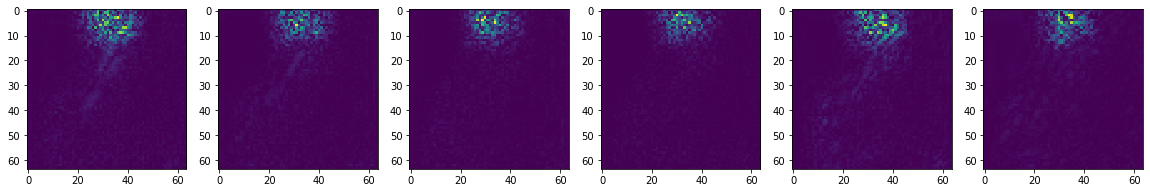

In [12]:
data_A_sample, data_B_sample = take_n_samples_random(data_A, data_B, 1)
index_x, index_y = (0, 32)
input_sample = torch.from_numpy(arr_to_input(data_A_sample)).cuda() if use_cuda else torch.from_numpy(arr_to_input(data_A_sample))
                                       
grads = generate_gradients(model, torch.autograd.Variable(input_sample, requires_grad = True), index_x, index_y)
fig, axes = plt.subplots(1,6, figsize = (20, 120))

for i in range(6):
    axes[i].imshow(np.abs(grads[i,:,:]))

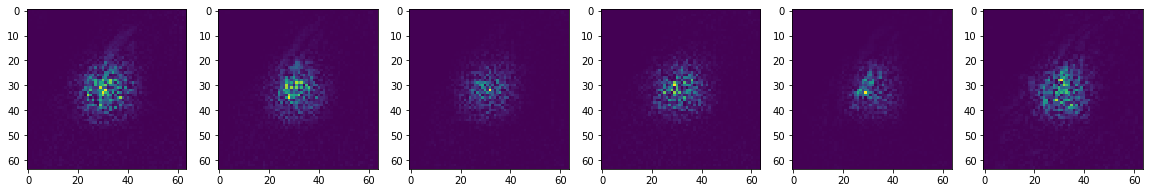

In [13]:
index_x, index_y = (32, 32)
input_sample = torch.from_numpy(arr_to_input(data_A_sample)).cuda() if use_cuda else torch.from_numpy(arr_to_input(data_A_sample))
                                       
grads = generate_gradients(model, torch.autograd.Variable(input_sample, requires_grad = True), index_x, index_y)
fig, axes = plt.subplots(1,6, figsize = (20, 120))

for i in range(6):
    axes[i].imshow(np.abs(grads[i,:,:]))

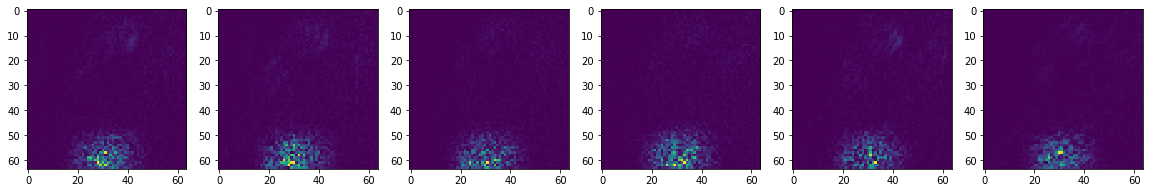

In [14]:
data_A_sample, data_B_sample = take_n_samples_random(data_A, data_B, 1)
index_x, index_y = (63, 32)
input_sample = torch.from_numpy(arr_to_input(data_A_sample)).cuda() if use_cuda else torch.from_numpy(arr_to_input(data_A_sample))
                                       
grads = generate_gradients(model, torch.autograd.Variable(input_sample, requires_grad = True), index_x, index_y)
fig, axes = plt.subplots(1,6, figsize = (20, 120))

for i in range(6):
    axes[i].imshow(np.abs(grads[i,:,:]))

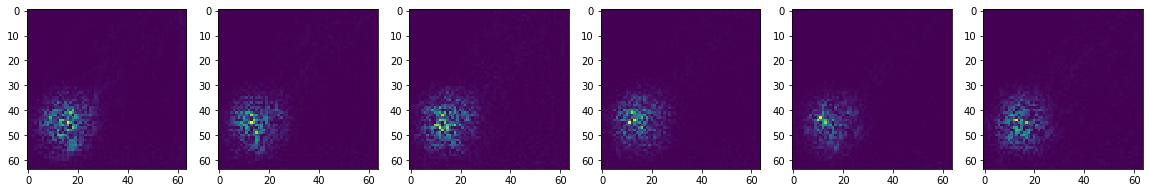

In [20]:
data_A_sample, data_B_sample = take_n_samples_random(data_A, data_B, 1)
index_x, index_y = (45, 15)
input_sample = torch.from_numpy(arr_to_input(data_A_sample)).cuda() if use_cuda else torch.from_numpy(arr_to_input(data_A_sample))
                                       
grads = generate_gradients(model, torch.autograd.Variable(input_sample, requires_grad = True), index_x, index_y)
fig, axes = plt.subplots(1,6, figsize = (20, 120))

for i in range(6):
    axes[i].imshow(np.abs(grads[i,:,:]))

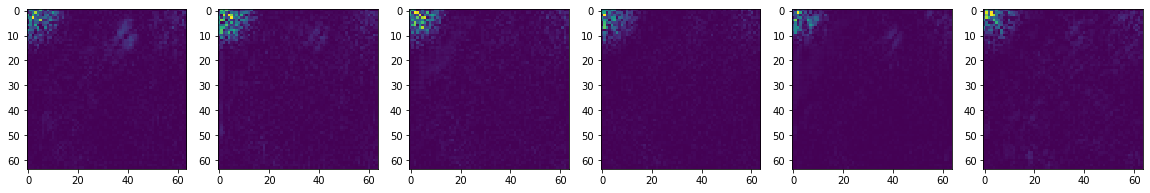

In [15]:
data_A_sample, data_B_sample = take_n_samples_random(data_A, data_B, 1)
index_x, index_y = (0, 0)
input_sample = torch.from_numpy(arr_to_input(data_A_sample)).cuda() if use_cuda else torch.from_numpy(arr_to_input(data_A_sample))
                                       
grads = generate_gradients(model, torch.autograd.Variable(input_sample, requires_grad = True), index_x, index_y)
fig, axes = plt.subplots(1,6, figsize = (20, 120))

for i in range(6):
    axes[i].imshow(np.abs(grads[i,:,:]))

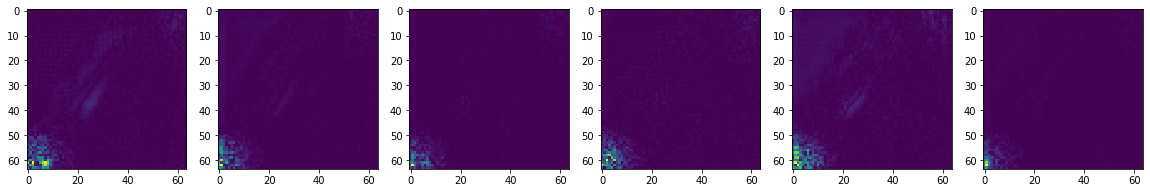

In [17]:
data_A_sample, data_B_sample = take_n_samples_random(data_A, data_B, 1)
index_x, index_y = (63, 0)
input_sample = torch.from_numpy(arr_to_input(data_A_sample)).cuda() if use_cuda else torch.from_numpy(arr_to_input(data_A_sample))
                                       
grads = generate_gradients(model, torch.autograd.Variable(input_sample, requires_grad = True), index_x, index_y)
fig, axes = plt.subplots(1,6, figsize = (20, 120))

for i in range(6):
    axes[i].imshow(np.abs(grads[i,:,:]))

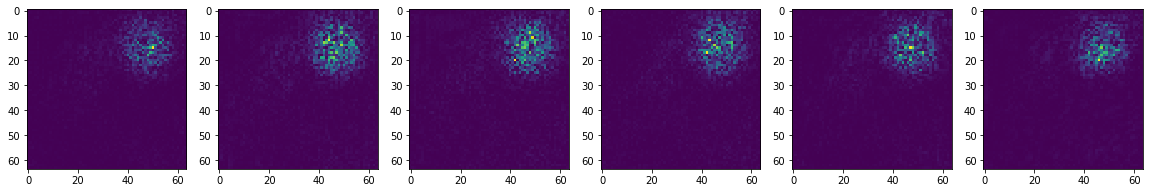

In [18]:
data_A_sample, data_B_sample = take_n_samples_random(data_A, data_B, 1)
index_x, index_y = (15, 45)
input_sample = torch.from_numpy(arr_to_input(data_A_sample)).cuda() if use_cuda else torch.from_numpy(arr_to_input(data_A_sample))
                                       
grads = generate_gradients(model, torch.autograd.Variable(input_sample, requires_grad = True), index_x, index_y)
fig, axes = plt.subplots(1,6, figsize = (20, 120))

for i in range(6):
    axes[i].imshow(np.abs(grads[i,:,:]))

In [19]:
model._modules.items()

odict_items([('model', Sequential(
  (0): ReflectionPad2d((3, 3, 3, 3))
  (1): Conv2d(6, 32, kernel_size=(7, 7), stride=(1, 1))
  (2): InstanceNorm()
  (3): ReLU(inplace)
  (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): InstanceNorm()
  (6): ReLU(inplace)
  (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (8): InstanceNorm()
  (9): ReLU(inplace)
  (10): ResnetBlock(
    (conv_block): Sequential(
      (0): ReflectionPad2d((1, 1, 1, 1))
      (1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
      (2): ReLU(inplace)
      (3): ReflectionPad2d((1, 1, 1, 1))
      (4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
      (5): InstanceNorm()
    )
    (relu): ReLU(inplace)
  )
  (11): ResnetBlock(
    (conv_block): Sequential(
      (0): ReflectionPad2d((1, 1, 1, 1))
      (1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
      (2): ReLU(inplace)
      (3): ReflectionPad2d((1, 1, 1, 1))
      (4): Conv2d(128, 128, k

# New heading